訓練データを入手して調査する
=========================


## データの入手

以下のコードを実行し，訓練データを読み込みます

In [1]:
import numpy as np
import pandas as pd
import pathlib

train_data_path = pathlib.Path("../input/spaceship-titanic/train.csv")
train_data = pd.read_csv(
    train_data_path,
    dtype={
        "PassengerId": "string",
        "HomePlanet": "string",
        "Cabin": "string",
        "Destination": "string",
    },
)

```{note}
Kaggle 上でノートブックを実行するとパスは Unix 形式になっていて区切り文字が `/` ですが，Windowsだと異なります．この違いを吸収するために `pathlib` ライブラリを使用しています．
```

このコンペティションではテストデータと訓練データはあらかじめ取り分けられていますので，ここで読んだデータが訓練データになります．

`head` メソッドで最初の５行を見てみます．

In [3]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


14個の列がありますが，この各列について与えられている説明は下記の通りです．


```{card}
- `PassengerId` - 各旅客のユニークな ID. 各 ID は `ggggg_pp` の形式をとり，`ggggg` は乗客が一緒に旅行しているグループ，`pp` はそのグループ内の番号です. グループ内の人は家族であることが多いですが，常に家族とは限りません
- `HomePlanet` - 旅客が出発した惑星で，通常は定住している惑星です.
- `CryoSleep` - 航海中，お客様が仮死状態になることを選択されたかどうかを示しています. 冷凍睡眠中のお客様は，キャビンに閉じ込められます.
- `Cabin` - 乗客が滞在するキャビン番号です. `deck/num/side` の形式で，side には P (Port)，S (Starboard) のいずれかが入ります.
- `Destination` - 乗客が降り立つ惑星です.
- `Age` - 搭乗者の年齢.
- `VIP` - 航海中に特別な VIP サービスを支払ったかどうか.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - 宇宙船タイタニック号の数々の豪華な設備で，お客様がそれぞれのサービスを利用した金額です.
- `Name` - 搭乗者の姓と名.
- `Transported` - 乗客が別の次元に転送されたかどうか. これがターゲットであり，予測しようとしている列です.
```

## 欠損値の調査

各列ごとに欠損値がどれだけあるかを調べます．

In [22]:
train_data.isnull().sum()

PassengerId         0
HomePlanet        201
CryoSleep         217
Cabin             199
Destination       182
Age               179
VIP               203
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Name              200
Transported         0
consuming_VSR     544
consuming_full    908
group               0
dtype: int64

PassengerId と Transported には欠損値がありませんが，それ以外の列には 100 ~ 200 行程度の欠損値があることがわかります．

In [23]:

train_data.shape[0]

8693

全体の行数は 8693 です．

## データを可視化する

### ヒストグラムを出力してみる


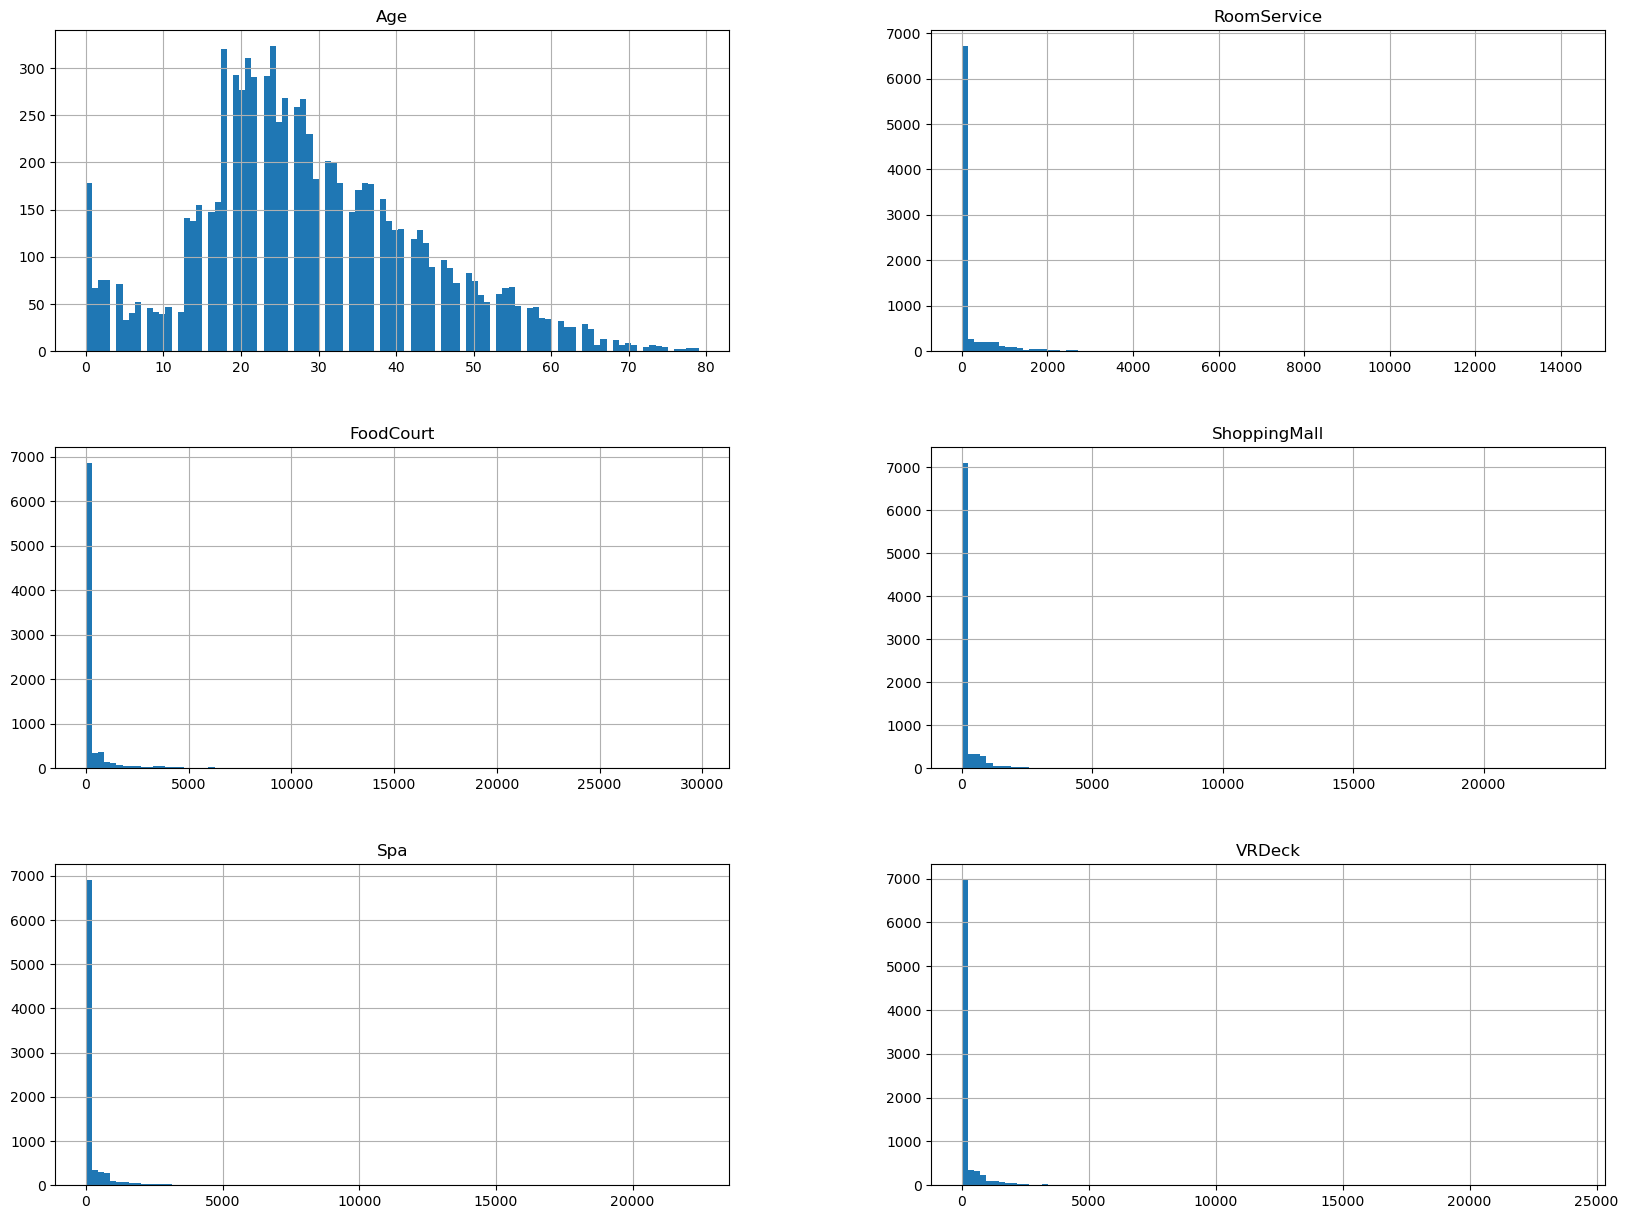

In [6]:
# ヒストグラムをプロットする
%matplotlib inline
import matplotlib.pyplot as plt

train_data.hist(bins=100, figsize=(20, 15))
plt.show()


ヒストグラムからわかること

- Age にはなぜか特定の年齢のひとがいないようだ. 一定の間隔で，該当者がゼロの年齢が現れる．
- Age 以外の５つの数値属性は，どれも０付近に値が偏っている


In [7]:
train_data["HomePlanet"].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: Int64

In [8]:
train_data["CryoSleep"].value_counts()

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

In [9]:
train_data["Cabin"].value_counts()

Cabin
G/734/S     8
B/82/S      7
G/109/P     7
B/11/S      7
F/1411/P    7
           ..
G/1339/S    1
F/1633/P    1
G/1350/P    1
B/309/S     1
F/947/P     1
Name: count, Length: 6560, dtype: Int64

In [10]:
train_data["Destination"].value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: Int64

In [11]:
train_data["VIP"].value_counts()

VIP
False    8291
True      199
Name: count, dtype: int64

In [12]:
train_data["Transported"].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

### サービスの消費額

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck の５つの数値属性の相関はどうなっているだろうか？


array([[<Axes: xlabel='RoomService', ylabel='RoomService'>,
        <Axes: xlabel='FoodCourt', ylabel='RoomService'>,
        <Axes: xlabel='ShoppingMall', ylabel='RoomService'>,
        <Axes: xlabel='Spa', ylabel='RoomService'>,
        <Axes: xlabel='VRDeck', ylabel='RoomService'>],
       [<Axes: xlabel='RoomService', ylabel='FoodCourt'>,
        <Axes: xlabel='FoodCourt', ylabel='FoodCourt'>,
        <Axes: xlabel='ShoppingMall', ylabel='FoodCourt'>,
        <Axes: xlabel='Spa', ylabel='FoodCourt'>,
        <Axes: xlabel='VRDeck', ylabel='FoodCourt'>],
       [<Axes: xlabel='RoomService', ylabel='ShoppingMall'>,
        <Axes: xlabel='FoodCourt', ylabel='ShoppingMall'>,
        <Axes: xlabel='ShoppingMall', ylabel='ShoppingMall'>,
        <Axes: xlabel='Spa', ylabel='ShoppingMall'>,
        <Axes: xlabel='VRDeck', ylabel='ShoppingMall'>],
       [<Axes: xlabel='RoomService', ylabel='Spa'>,
        <Axes: xlabel='FoodCourt', ylabel='Spa'>,
        <Axes: xlabel='ShoppingMall', ylab

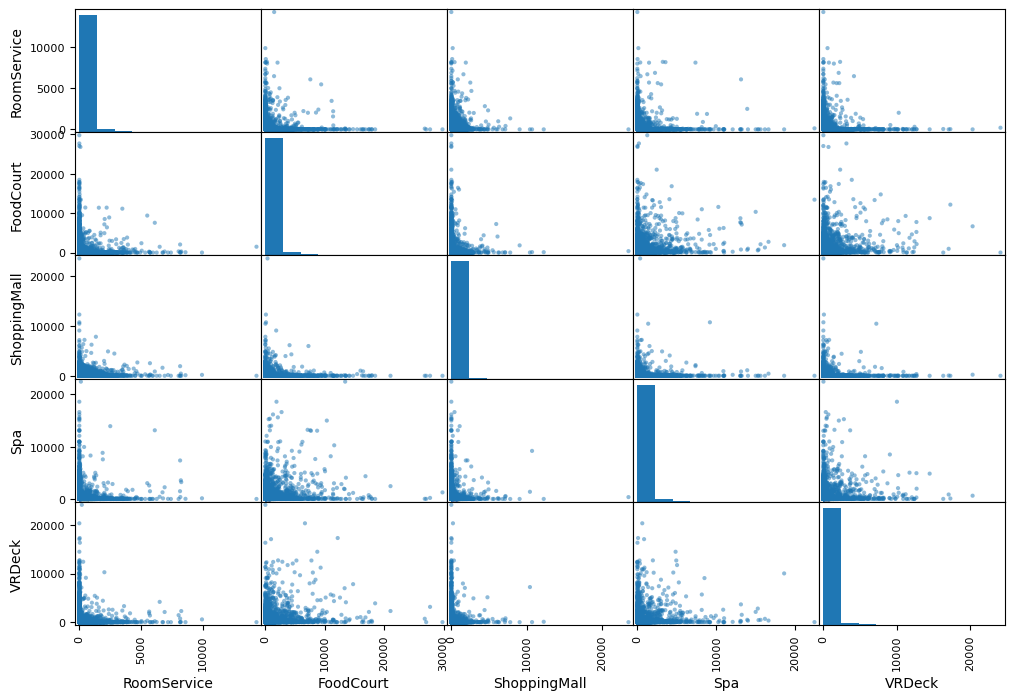

In [13]:
from pandas.plotting import scatter_matrix

attributes = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
scatter_matrix(train_data[attributes], figsize=(12, 8))

ヒストグラムは似ているが，相関はどれに関してもほとんどないようだ


予測対象のカラムに対する相関関係を調べてみよう


In [14]:
corr_matrix = train_data.corr(numeric_only=True)

corr_matrix["Transported"].sort_values(ascending=False)

Transported     1.000000
FoodCourt       0.046566
ShoppingMall    0.010141
Age            -0.075026
VRDeck         -0.207075
Spa            -0.221131
RoomService    -0.244611
Name: Transported, dtype: float64

サービスに対する消費額が大きいほど，Transport されにくいという結果が出ている
この特徴量を組み合わせてみたらどうだろうか？


In [15]:
train_data["consuming_VSR"] = (
    train_data["VRDeck"] + train_data["Spa"] + train_data["RoomService"]
)
train_data["consuming_full"] = (
    train_data["VRDeck"]
    + train_data["Spa"]
    + train_data["RoomService"]
    + train_data["FoodCourt"]
    + train_data["ShoppingMall"]
)

corr_matrix = train_data.corr(numeric_only=True)
corr_matrix["Transported"].sort_values(ascending=False)

Transported       1.000000
FoodCourt         0.046566
ShoppingMall      0.010141
Age              -0.075026
consuming_full   -0.197671
VRDeck           -0.207075
Spa              -0.221131
RoomService      -0.244611
consuming_VSR    -0.356140
Name: Transported, dtype: float64

相関がずっと大きくなった！特に，VR と Spa と RoomService の組み合わせが良いようだ


### グループ内で一貫性があるかどうか

同じグループで区切ったときに，グループ内で Transport するかどうかは一致するだろうか？
後で調べるために，group という属性を追加しておく


In [16]:
train_data["group"] = train_data["PassengerId"].map(lambda x: x.split("_")[0])
train_data["group"]

0       0001
1       0002
2       0003
3       0003
4       0004
        ... 
8688    9276
8689    9278
8690    9279
8691    9280
8692    9280
Name: group, Length: 8693, dtype: object

カテゴリ変数を調べる


In [17]:
transported_and_sleep = train_data[["Transported", "CryoSleep", "PassengerId"]].groupby(["Transported", "CryoSleep"]).count()
transported_and_sleep


PassengerId
Transported CryoSleep             
False       False             3650
            True               554
True        False             1789
            True              2483

In [18]:
# クロス集計した表を作る
cross_data = pd.crosstab(
    train_data["CryoSleep"], train_data["Transported"], normalize="index"
)
cross_data

Transported,False,True
CryoSleep,,
False,0.671079,0.328921
True,0.182417,0.817583


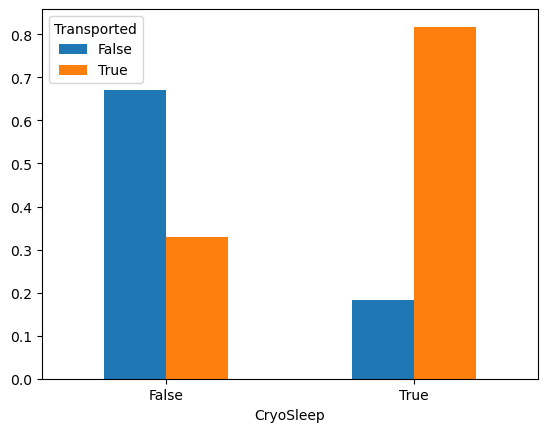

In [19]:
# 棒グラフとして表示する
barplot = cross_data.plot.bar(rot=0)

## 不要な属性を取り除く


In [20]:
# Name 属性は予測の役に立たないと思われるので削除する
# train_data = train_data.drop("Name", axis=1)
# train_data.head()